In [64]:
import os
import tensorflow as tf
import numpy as np
import helper
import matplotlib.pyplot as plt
import scipy.misc
import imageio
from PIL import Image
from PIL import ImageDraw
from PIL import ImageColor

import warnings
warnings.filterwarnings('ignore')

In [65]:
"""
	Apply segmentation to one image
	:param sess: TF session
	:param logits: TF Tensor for the logits
	:param keep_prob: TF Placeholder for the dropout keep probability
	:param image_pl: TF Placeholder for the image placeholder
	:param image_array: Path to the folder that contains the datasets
	:param image_shape: Tuple - Shape of image
	:return: Immage array
	"""

def apply_inference(sess, logits, keep_prob, image_pl, image, image_shape):
    original_shape = (375, 1242)
    
    image_array =  scipy.misc.imresize(image, image_shape)
    
    im_softmax = sess.run([tf.nn.softmax(logits)], {keep_prob: 1.0, image_pl: [image_array]})
    # Splice out second column (road), reshape output back to image_shape
    im_softmax = im_softmax[0][:, 1].reshape(image_shape[0], image_shape[1])

    # If road softmax > 0.5, prediction is road
    segmentation = (im_softmax > 0.5).reshape(image_shape[0], image_shape[1], 1)
    
    original_shape = (375, 1242)

    # Create mask based on segmentation to apply to original image
    overlay = np.dot(segmentation, np.array([[0, 255, 0, 127]]))
    overlay = scipy.misc.toimage(overlay, mode="RGBA")
    overlay = scipy.misc.imresize(overlay, original_shape)
    
    bit_mask = overlay[:,:,1] > 127
    bit_mask = bit_mask.reshape(original_shape[0], original_shape[1], 1)
    bit_mask = np.dot(bit_mask, np.array([[255, 255, 255, 127]]))

    # Prepare PIL images
    mask = scipy.misc.toimage(bit_mask, mode="RGBA")
    overlay = Image.fromarray(overlay, mode="RGBA")
    street_im = Image.fromarray(image)
    
    # Paste overlay into original image
    street_im.paste(overlay, None, mask)

    return np.array(street_im)
    

['Epochs10_Batch16_KeepProb0.5_LearnRate0.001_Loss0.179', '1546796577.0003972']
Loading model from ./runs/Epochs10_Batch16_KeepProb0.5_LearnRate0.001_Loss0.179/model
INFO:tensorflow:Restoring parameters from ./runs/Epochs10_Batch16_KeepProb0.5_LearnRate0.001_Loss0.179/model/model


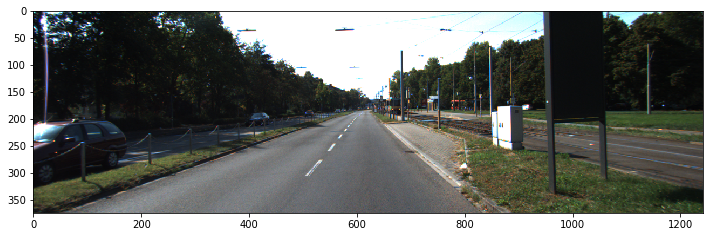

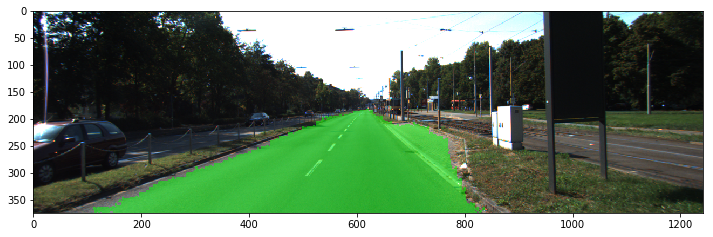

In [66]:
run_dir = "./runs"
test_dir = "./data/data_road/testing/image_2"

runs = [d for d in os.listdir(run_dir) if os.path.isdir(os.path.join(run_dir, d))]
print(runs)

# When sorted alphabetically by loss, the first should be the best one
model_dir = os.path.join(run_dir,runs[0] +'/model')  

print(f"Loading model from {model_dir}")

with tf.Session(graph=tf.Graph()) as sess:
    saver = tf.train.import_meta_graph(model_dir+'/model.meta')
    saver.restore(sess, tf.train.latest_checkpoint(model_dir))
  
    test_image = os.path.join(test_dir, 'um_000000.png')
    image_shape = (160, 576) 
    
    image = imageio.imread(test_image)
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    
    graph = tf.get_default_graph()
    image_tensor = graph.get_tensor_by_name("image_input:0")
    logits_tensor = graph.get_tensor_by_name("logits:0")
    keep_prob_tensor = graph.get_tensor_by_name("keep_prob:0")
    
    seg_img = apply_inference(sess, logits_tensor, keep_prob_tensor, image_tensor, image, image_shape)
    plt.figure(figsize=(12, 8))
    plt.imshow(seg_img) 
                              
